In [1]:
import numpy as np

import matplotlib.pyplot as plt

from numba import njit, vectorize, float32

from monk import nb

from typing import Callable, Optional

import hoomd
import hoomd.forward_flux.forward_flux as ffs
import gsd.hoomd

from monk import prep
from monk import pair
import ex_render

from monk import nb

In [2]:
cpu = hoomd.device.CPU()
seed = 3412
sim = ffs.ForwardFluxSimulation(cpu, 20, seed=seed)

In [3]:
sim.create_state_from_gsd("equil-system-T0.1.gsd")

In [4]:
from hoomd.custom import Action
import freud
import time

class TrackParticle(Action):

    def __init__(self, pid):
        self._pid = pid
        self.data = []

    def act(self, timestep):
        # if isinstance(self._simulation.device, hoomd.device.CPU):
        with self._state.cpu_local_snapshot as data:
            idx = data.particles.rtag[self._pid]
            self.data.append(np.array(data.particles.position[idx], copy=True))

@njit
def _diff_with_rtag(ref_pos, pos, rtags):
    out = np.zeros_like(pos)
    n = len(rtags)
    for tag_idx in range(n):
        idx = rtags[tag_idx]
        out[idx] = pos[idx] - ref_pos[tag_idx]
    return out

class ZeroDrift(Action):

    def __init__(self, reference_positions, box):
        self._ref_pos = reference_positions
        self._box = freud.box.Box.from_box(box)
        # self._imgs = np.array([0.0, 0.0, 0.0])

    @classmethod
    def from_state(cls, state: hoomd.State):
        return cls(state.get_snapshot().particles.position, state.box)

    def act(self, timestep):
        with self._state.cpu_local_snapshot as data:
            pos = data.particles.position._coerce_to_ndarray()
            rtags = data.particles.rtag._coerce_to_ndarray()
            diff = self._box.wrap(_diff_with_rtag(self._ref_pos, pos, rtags))
            # plt.hist(diff)
            # plt.yscale('log')
            # plt.show()
            # time.sleep(1.0)
            dx = np.mean(diff, axis=0)
            data.particles.position = self._box.wrap(data.particles.position - dx)


In [5]:
integrator = hoomd.md.Integrator(dt=0.0025)
tree = hoomd.md.nlist.Tree(0.3)
# lj = pair.KA_LJ_DPD(tree, 0.1)
lj = pair.KA_LJ(tree)
# swap_forces = [lj_swap]

lang = hoomd.md.methods.Langevin(hoomd.filter.All(), 0.1)
# lang = hoomd.md.methods.NVE(hoomd.filter.All())
integrator.forces = [lj]
integrator.methods = [lang]
sim.operations.integrator = integrator

# set zero drift
pos = sim.state.get_snapshot().particles.position
box = sim.state.box
trigger = hoomd.trigger.Periodic(1)
remove_drift = hoomd.update.CustomUpdater(trigger, ZeroDrift(pos, box))
sim.operations.updaters.clear()
sim.operations.updaters.append(remove_drift)

# trigger = hoomd.trigger.Periodic(1)
# tracker = hoomd.write.CustomWriter(trigger, TrackParticle(20))
# sim.operations.writers.append(tracker)

# add writer
writer = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(10), filename="another-test4.gsd", mode="wb", filter=hoomd.filter.All())
# sim.operations.writers.clear()
# sim.operations.writers.append(writer)

In [6]:
sim.run(0)

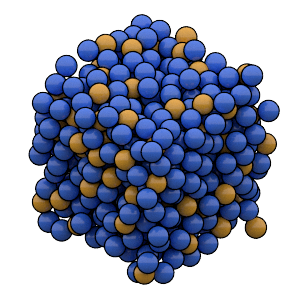

In [7]:
ex_render.render_sphere_frame(frame=sim.state.get_snapshot())

In [6]:
sim.run(100_000)

In [9]:
basin_op = sim.sample_basin(10_000, 1)

In [10]:
sim.basin_barrier = np.quantile(basin_op, 0.99)
sim.basin_barrier

0.13644894884280268

In [15]:
sim.basin_barrier = 0.1

In [ ]:
sim.basin_barrier = 0.12314449904250506

Text(0, 0.5, '$P(\\Delta r)$')

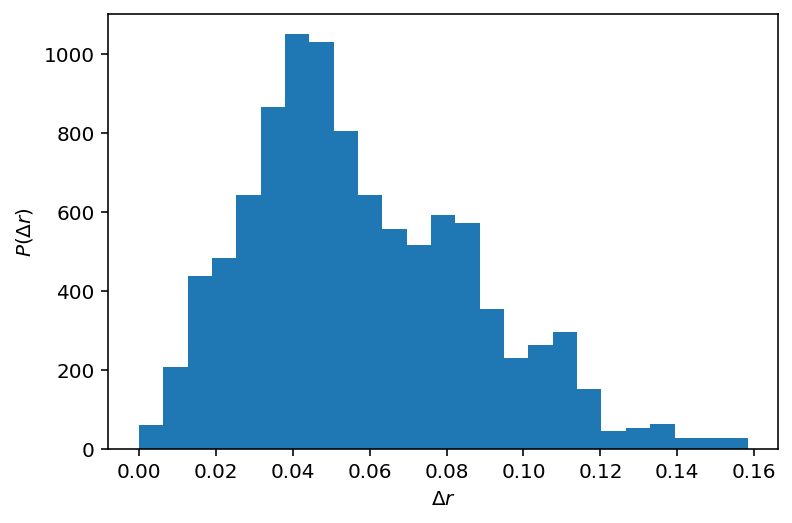

In [11]:
plt.hist(basin_op, bins=25)
plt.xlabel(r"$\Delta r$")
plt.ylabel(r"$P(\Delta r)$")

Text(0.5, 0, '$t$')

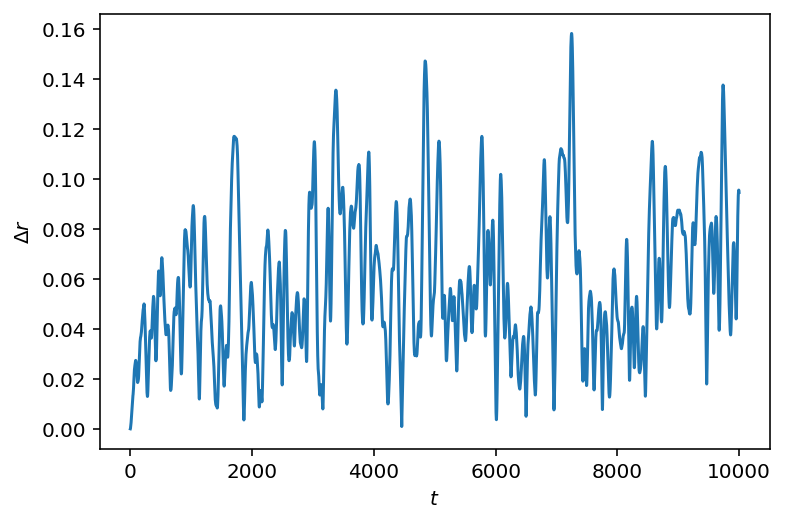

In [12]:
plt.plot(basin_op)
plt.ylabel(r"$\Delta r$")
plt.xlabel(r"$t$")

In [13]:
sim.operations.updaters.clear()

In [19]:
sim.seed = 100

In [25]:
sim.reset_state()
sim.run_ff(2_000, trials=1000, op_thresh=0.5)

Crossing: 6
state: 0
0 None
1 None
2 None
3 None
4 None
5 None
6 None
7 None
8 None
9 None
10 None
11 None
12 None
13 None
14 None
15 None
16 None
17 None
18 None
19 None
20 None
21 None
22 None
23 None
24 None
25 None
26 None
27 None
28 None
29 None
30 None
31 None
32 None
33 None
34 None
35 None
36 None
37 None
38 None
39 None
40 None
41 None
42 None
43 None
44 None
45 None
46 None
47 None
48 None
49 None
50 None
51 None
52 None
53 None
54 None
55 None
56 None
57 None
58 None
59 None
60 None
61 None
62 None
63 None
64 None
65 None
66 None
67 None
68 None
69 None
70 None
71 None
72 None
73 None
74 None
75 None
76 None
77 None
78 None
79 None
80 None
81 None
82 None
83 None
84 None
85 None
86 None
87 None
88 None
89 None
90 None
91 None
92 None
93 None
94 None
95 None
96 None
97 None
98 None
99 None
100 None
101 None
102 None
103 None
104 None
105 None
106 None
107 None
108 None
109 None
110 None
111 None
112 None
113 None
114 None
115 None
116 None
117 None
118 None
119 None
120 None


0.0

In [11]:
writer = hoomd.write.GSD(trigger=hoomd.trigger.Periodic(10), filename="another-test2.gsd", mode="xb", filter=hoomd.filter.All())
sim.operations.writers.clear()
sim.operations.writers.append(writer)
sim.run(100_000)